In [1]:
import numpy as np
import networkx as nx
import seaborn as sns
import csaps

import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from sklearn.linear_model import LinearRegression

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Avenir"
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def approximate(s = 0, mu = 1e-4, amp = 1, lamb = 1, N = 1000):

    idx = np.arange(0, N + 1)
    d = (2 + amp * s) * (N - idx) + mu / lamb * idx * (1 + amp * s)
    a = (N - idx) / d
    b = (N - idx) * (1 - mu / lamb) * (1 + amp * s) / d
    c = N * mu / lamb * (1 + amp * s) / d

    alpha = np.zeros(N)
    beta = np.zeros(N)
    alpha[N - 1] = a[N - 1]
    beta[N - 1] = b[N - 1] + c[N - 1]
    for i in idx[1:-2][::-1]:
        beta[i] = (b[i] * beta[i + 1] + c[i]) / (1 - b[i] * alpha[i + 1])
        alpha[i] = a[i] / (1 - b[i] * alpha[i + 1])
        
    return beta[1]


def approximate_t(s = 0, mu = 1e-4, amp = 1, lamb = 1, N = 100):
    idx = np.arange(1, N) 
    W = (N + idx * s)
    P1 = np.eye(N + 2) 
    P1[idx, idx - 1] = lamb * 1 / W * idx * (1 - idx / N) 
    P1[idx, idx + 1] = lamb * (1 + amp * s) / W * idx * (1 - idx / N) 
    P1[idx, idx] -=  (P1[idx, idx - 1] + P1[idx, idx + 1])
    P1[idx, idx] -= mu * (1 + s) / W * idx  * idx / N 
    P1[idx, idx + 1] -= mu * (1 + s) / W * idx * (1 - idx / N) 
    P1[idx, N + 1] += mu * (1 + s) / W * idx 
    P1[N, N] -= mu
    P1[N, N + 1] += mu 
    
    F = np.linalg.inv(np.eye(N) - P1[1:N + 1, 1:N + 1]) 
    pfix = F @ P1[1:-1, [0,-1]]
    
    return F[0] @ pfix[:,1] / pfix[0,1]


def trans(x,y, s = 0.999, pad = 2 * [0.05]):
    idx = np.isnan(y) == False
    x = x[idx]
    y = y[idx]
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    idx = np.unique(x, return_index=True)[1]
    
    x = x[idx]
    y = y[idx]
    sp = csaps.CubicSmoothingSpline(x, y, smooth=s)
    
    xs = np.linspace(x.min() - pad[0], x.max() + pad[1], 100)
    ys = sp(xs)
    return xs,ys
    
def process(key, N = 100, approx = False):
    path = ""
    #N = 100
    data_bd = np.zeros((3*N,3))
    raw_bd = np.loadtxt(path + key + '_results_bd.txt')
    raw_bd = np.vstack([raw_bd[::3,:], raw_bd[1::3,:], raw_bd[2::3,:] ])

    data_bd[:,0] = raw_bd[:,0]
    data_bd[:,1] = raw_bd[:,2] / (raw_bd[:,1] + raw_bd[:,2])
    data_bd[:,2] = raw_bd[:,4] #/ raw_bd[:,2]
    data_bd[:,2][np.where(data_bd[:,2] == 0)] = np.nan    
    data_db = np.zeros((3*N,3))
    raw_db = np.loadtxt(path + key + '_results_db.txt')
    raw_db = np.vstack([raw_db[::3,:], raw_db[1::3,:], raw_db[2::3,:] ])

    data_db[:,0] = raw_db[:,0]
    data_db[:,1] = raw_db[:,2] / (raw_db[:,1] + raw_db[:,2])
    data_db[:,2] = raw_db[:,4] #/ raw_db[:,2]
    data_db[:,2][np.where(data_db[:,2] == 0)] = np.nan 
    
    print("done")
    return data_bd, data_db


def process_s(key, N = 45, approx = False):
    path = ""
    data_bd = np.zeros((N, 3))
    raw_bd = np.loadtxt(path + key + '_results_bd.txt')

    data_bd[:,0] = raw_bd[:,0]
    data_bd[:,1] = raw_bd[:,2] / (raw_bd[:,1] + raw_bd[:,2])
    data_bd[:,2] = raw_bd[:,4] #/ raw_bd[:,2]
    data_bd[:,2][np.where(data_bd[:,2] == 0)] = np.nan    
    
    data_db = np.zeros((N,3))
    raw_db = np.loadtxt(path + key + '_results_db.txt')
    data_db[:,0] = raw_db[:,0]
    data_db[:,1] = raw_db[:,2] / (raw_db[:,1] + raw_db[:,2])
    data_db[:,2] = raw_db[:,4] #/ raw_db[:,2]
    data_db[:,2][np.where(data_db[:,2] == 0)] = np.nan 
    
    print("done")
    return data_bd, data_db

# Figure S1

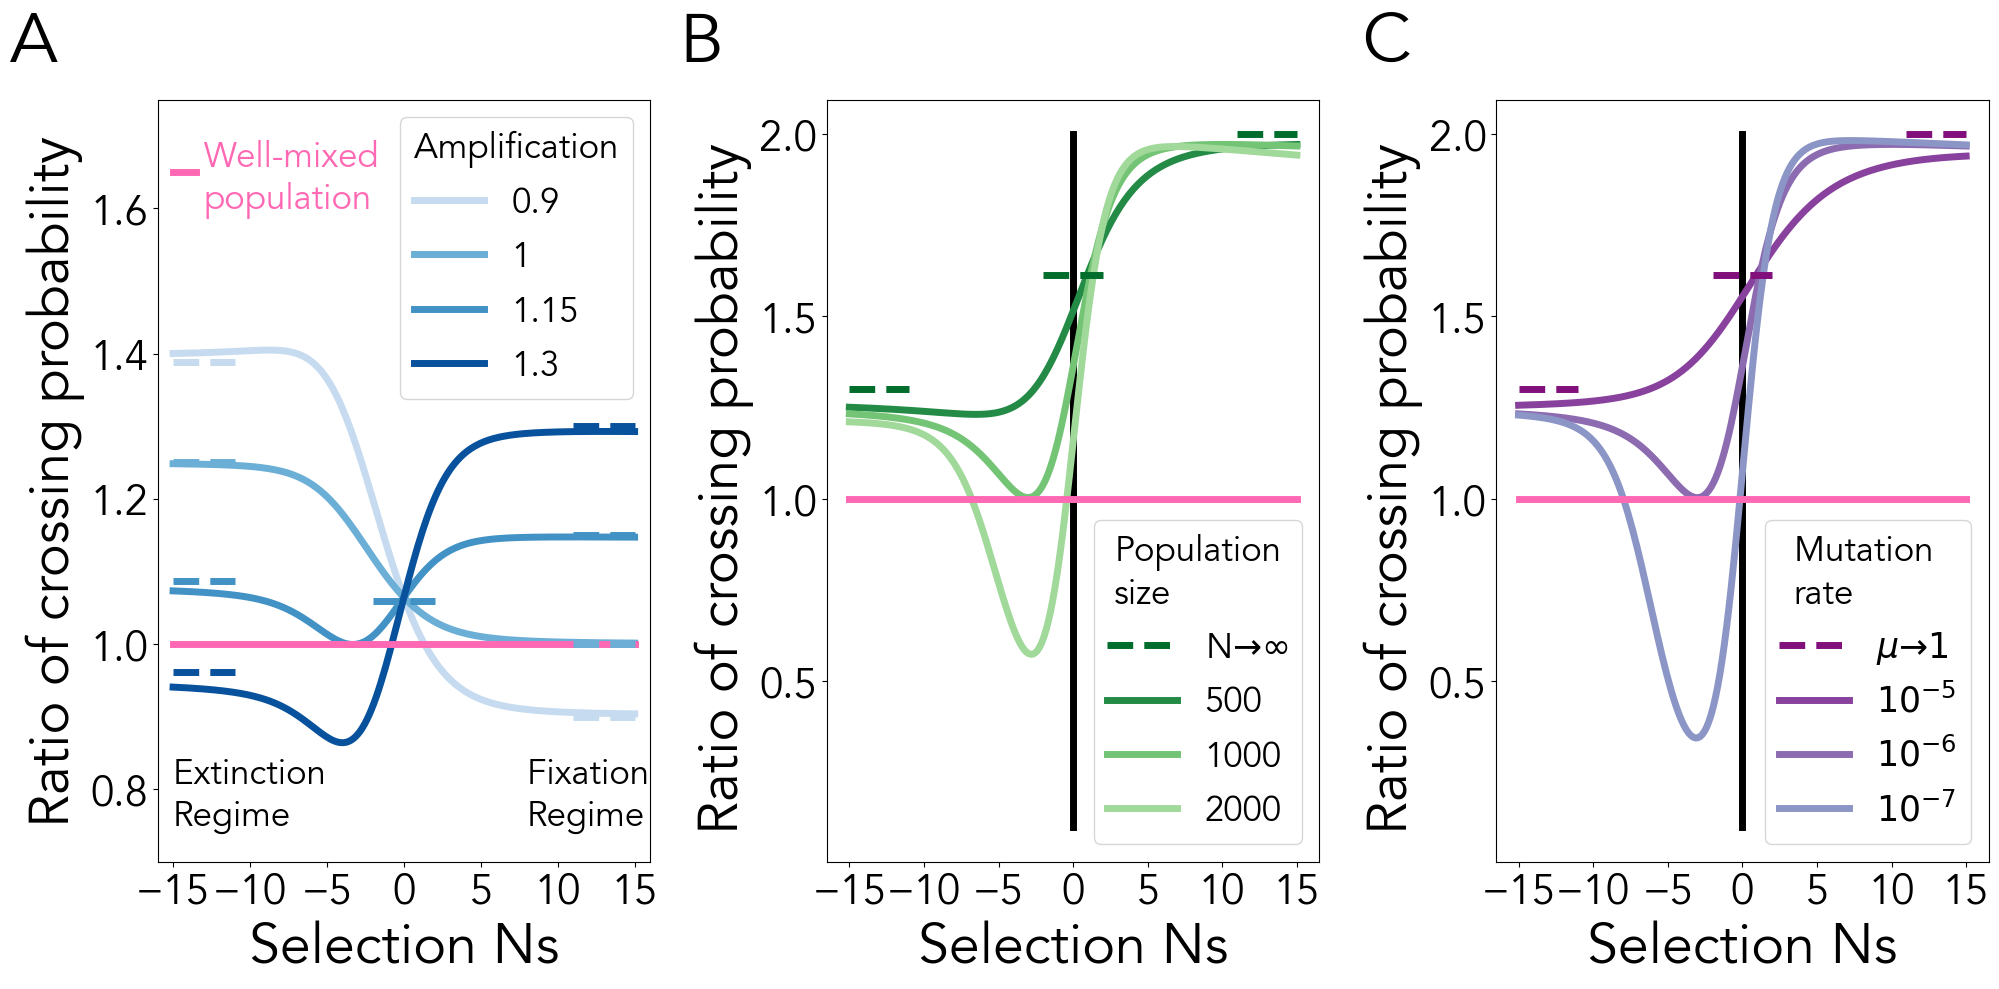

In [3]:
mu =  1e-6

plt.figure(figsize = (20,10))
s = np.linspace(-0.015,0.015, 201)
c = ['#c6dbef', '#6baed6', '#4292c6', '#08519c']
sns.set_palette(c)
ax = plt.subplot(131)

s = np.linspace(-0.015,0.015, 201)
y1 = np.array([approximate(s = s, mu = mu, amp = 0.9, lamb = 0.8, N = 1000) for s in s])
y2 = np.array([approximate(s = s, mu = mu, amp = 1, lamb = 0.8) for s in s])
y3 = np.array([approximate(s = s, mu = mu, amp = 1.15, lamb = 0.8) for s in s])
y4 = np.array([approximate(s = s, mu = mu, amp = 1.3, lamb = 0.8) for s in s])

z1 = np.array([approximate(s = s, mu = mu) for s in s])
z2 = np.array([approximate(s = s, mu = mu) for s in s])
z3 = np.array([approximate(s = s, mu = mu) for s in s])
z4 = np.array([approximate(s = s, mu = mu) for s in s])

plt.plot(1000 * s, (y1/z1), linewidth = 5)

plt.plot(1000 * s, (y2/z2), linewidth = 5)

plt.plot(1000 * s, (y3/z3), linewidth = 5)

plt.plot(1000 * s, (y4/z4), linewidth = 5)

plt.plot([-15,15], 2 * [1], linewidth = 5, c = '#ff69b4')
plt.plot([0,0],[0.8, 1.55], 'k', linewidth = 0, zorder = -1)

plt.plot([-15,-11], 2 * [1 / 0.8/ 0.9], linewidth = 5, linestyle = '--')
plt.plot([-15,-11], 2 * [1 / 0.8], linewidth = 5, linestyle = '--')
plt.plot([-15,-11], 2 * [1 / 0.8/1.15], linewidth = 5, linestyle = '--')
plt.plot([-15,-11], 2 * [1 / 0.8/1.3], linewidth = 5, linestyle = '--')

plt.plot([11,15], 2 * [0.9], linewidth = 5, linestyle = '--')
plt.plot([11,15], 2 * [1], linewidth = 5, linestyle = '--')
plt.plot([11,15], 2 * [1.15], linewidth = 5, linestyle = '--')
plt.plot([11,15], 2 * [1.3], linewidth = 5, linestyle = '--')

plt.plot([-2,2], 2 * [(1/1000 + np.sqrt(mu/0.8)) / (1/1000 + np.sqrt(mu))], 
         linewidth = 5, linestyle = '--', c = '#4292c6')

plt.plot([-15,-13.5], 2 * [1.65], linewidth = 5, c = '#ff69b4')
plt.text(-13, 1.6,'Well-mixed \npopulation', fontsize = 25, c = '#ff69b4')
plt.text(-15, .75,'Extinction \nRegime', fontsize = 25)
plt.text(8, .75,'Fixation \nRegime', fontsize = 25)

plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.xlabel('Selection Ns', fontsize = 40)
plt.ylabel('Ratio of crossing probability', fontsize = 40)


leg = plt.legend(['0.9', '1', '1.15', '1.3'], fontsize = 25,
          title = 'Amplification', title_fontsize=25, loc = 'upper right')
leg._legend_box.align = "left"

plt.xlim(-16,16)
plt.ylim(0.7,1.75)
plt.text(-0.3, 1.05, 'A', fontsize = 50, transform=ax.transAxes)

################################################################################

c = ['#006d2c','#238b45','#74c476', '#a1d99b'][1:]
sns.set_palette(c)

ax = plt.subplot(132)
mu = 1e-6
ns = np.linspace(-15, 15, 201)

plt.plot([], [], linewidth = 5, linestyle = '--', c = '#006d2c')

N = 2000
s = ns / N
y = np.array([approximate(s = s, mu = mu, amp = 2, lamb = 1 / 2.6, N = N) for s in s])
z = np.array([approximate(s = s, mu = mu, N = N) for s in s])
plt.plot(N * s, y / z, linewidth = 5)

N = 1000
s = ns / N
y = np.array([approximate(s = s, mu = mu, amp = 2, lamb = 1 / 2.6, N = N) for s in s])
z = np.array([approximate(s = s, mu = mu, N = N) for s in s])
plt.plot(N * s, y / z, linewidth = 5)


N = 500
s = ns / N
y = np.array([approximate(s = s, mu = mu, amp = 2, lamb = 1 / 2.6, N = N) for s in s])
z = np.array([approximate(s = s, mu = mu, N = N) for s in s])
plt.plot(N * s, y / z, linewidth = 5)

plt.plot([-15,-11], 2*[1.3], linewidth = 5, linestyle = '--', c = '#006d2c')
plt.plot([-2,2], 2*[np.sqrt(2.6)], linewidth = 5, linestyle = '--', c = '#006d2c')
plt.plot([11,15], 2*[2], linewidth = 5, linestyle = '--', c = '#006d2c')

plt.plot([0,0], [0.1, 2], 'k', linewidth = 5, zorder = -1)
plt.plot([-15,15], [1,1], c = '#ff69b4', linewidth = 5)

plt.xticks(fontsize = 30)
plt.yticks([0.5,1,1.5,2], fontsize = 30)

plt.xlabel('Selection Ns', fontsize = 40)
plt.ylabel('Ratio of crossing probability ', fontsize = 40)

plt.legend(['N$\\to \infty$',500,1000,2000], title = 'Population\nsize', 
           title_fontsize = 25, fontsize = 25, loc = 'lower right')

plt.text(-0.3, 1.05, 'B', fontsize = 50, transform=ax.transAxes)

################################################################################
c = ['#8c96c6', '#8c6bb1', '#88419d'][::-1]
sns.set_palette(c)

ax = plt.subplot(133)

plt.plot([], [], linewidth = 5, linestyle = '--', c = '#810f7c')

mu = 1e-5
N = 1000
s = np.linspace(-0.015,0.015, 201)
y = np.array([approximate(s = s, mu = mu, amp = 2, lamb = 1 / 2.6) for s in s])
z = np.array([approximate(s = s, mu = mu) for s in s])
plt.plot(1000 * s, y / z, linewidth = 5)

mu = 1e-6
y = np.array([approximate(s = s, mu = mu, amp = 2, lamb = 1 / 2.6) for s in s])
z = np.array([approximate(s = s, mu = mu) for s in s])
plt.plot(1000 * s, y / z, linewidth = 5)

mu = 1e-7
y = np.array([approximate(s = s, mu = mu, amp = 2, lamb = 1 / 2.6) for s in s])
z = np.array([approximate(s = s, mu = mu) for s in s])
plt.plot(1000 * s, y / z, linewidth = 5)

plt.plot([-15,-11],2*[1.3], linewidth = 5, linestyle = '--', c = '#810f7c')
plt.plot([-2,2],2*[np.sqrt(2.6)], linewidth = 5, linestyle = '--', c = '#810f7c')
plt.plot([11,15],2*[2], linewidth = 5, linestyle = '--', c = '#810f7c')


plt.plot([0,0],[0.1, 2], 'k', linewidth = 5, zorder = -1)
plt.plot([-15,15],[1,1], c = '#ff69b4', linewidth = 5)

plt.xticks(fontsize = 30)
plt.yticks([0.5,1,1.5,2], fontsize = 30)

plt.xlabel('Selection Ns', fontsize = 40)
plt.ylabel('Ratio of crossing probability ', fontsize = 40)

plt.legend(['$\mu \\to 1$','$10^{-5}$','$10^{-6}$','$10^{-7}$'], title = 'Mutation \nrate', 
           title_fontsize = 25, fontsize = 25, loc = 'lower right')

plt.text(-0.35, 1.05, '  C', fontsize = 50, transform=ax.transAxes)

plt.tight_layout()
#plt.savefig('4intuition.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Figure S2

In [4]:
results_bd, results_db = process('1e-4', 800)
control_bd, _ = process_s('wm-4s')

data = np.loadtxt('reg_x4_param.txt', comments='#')

done
done


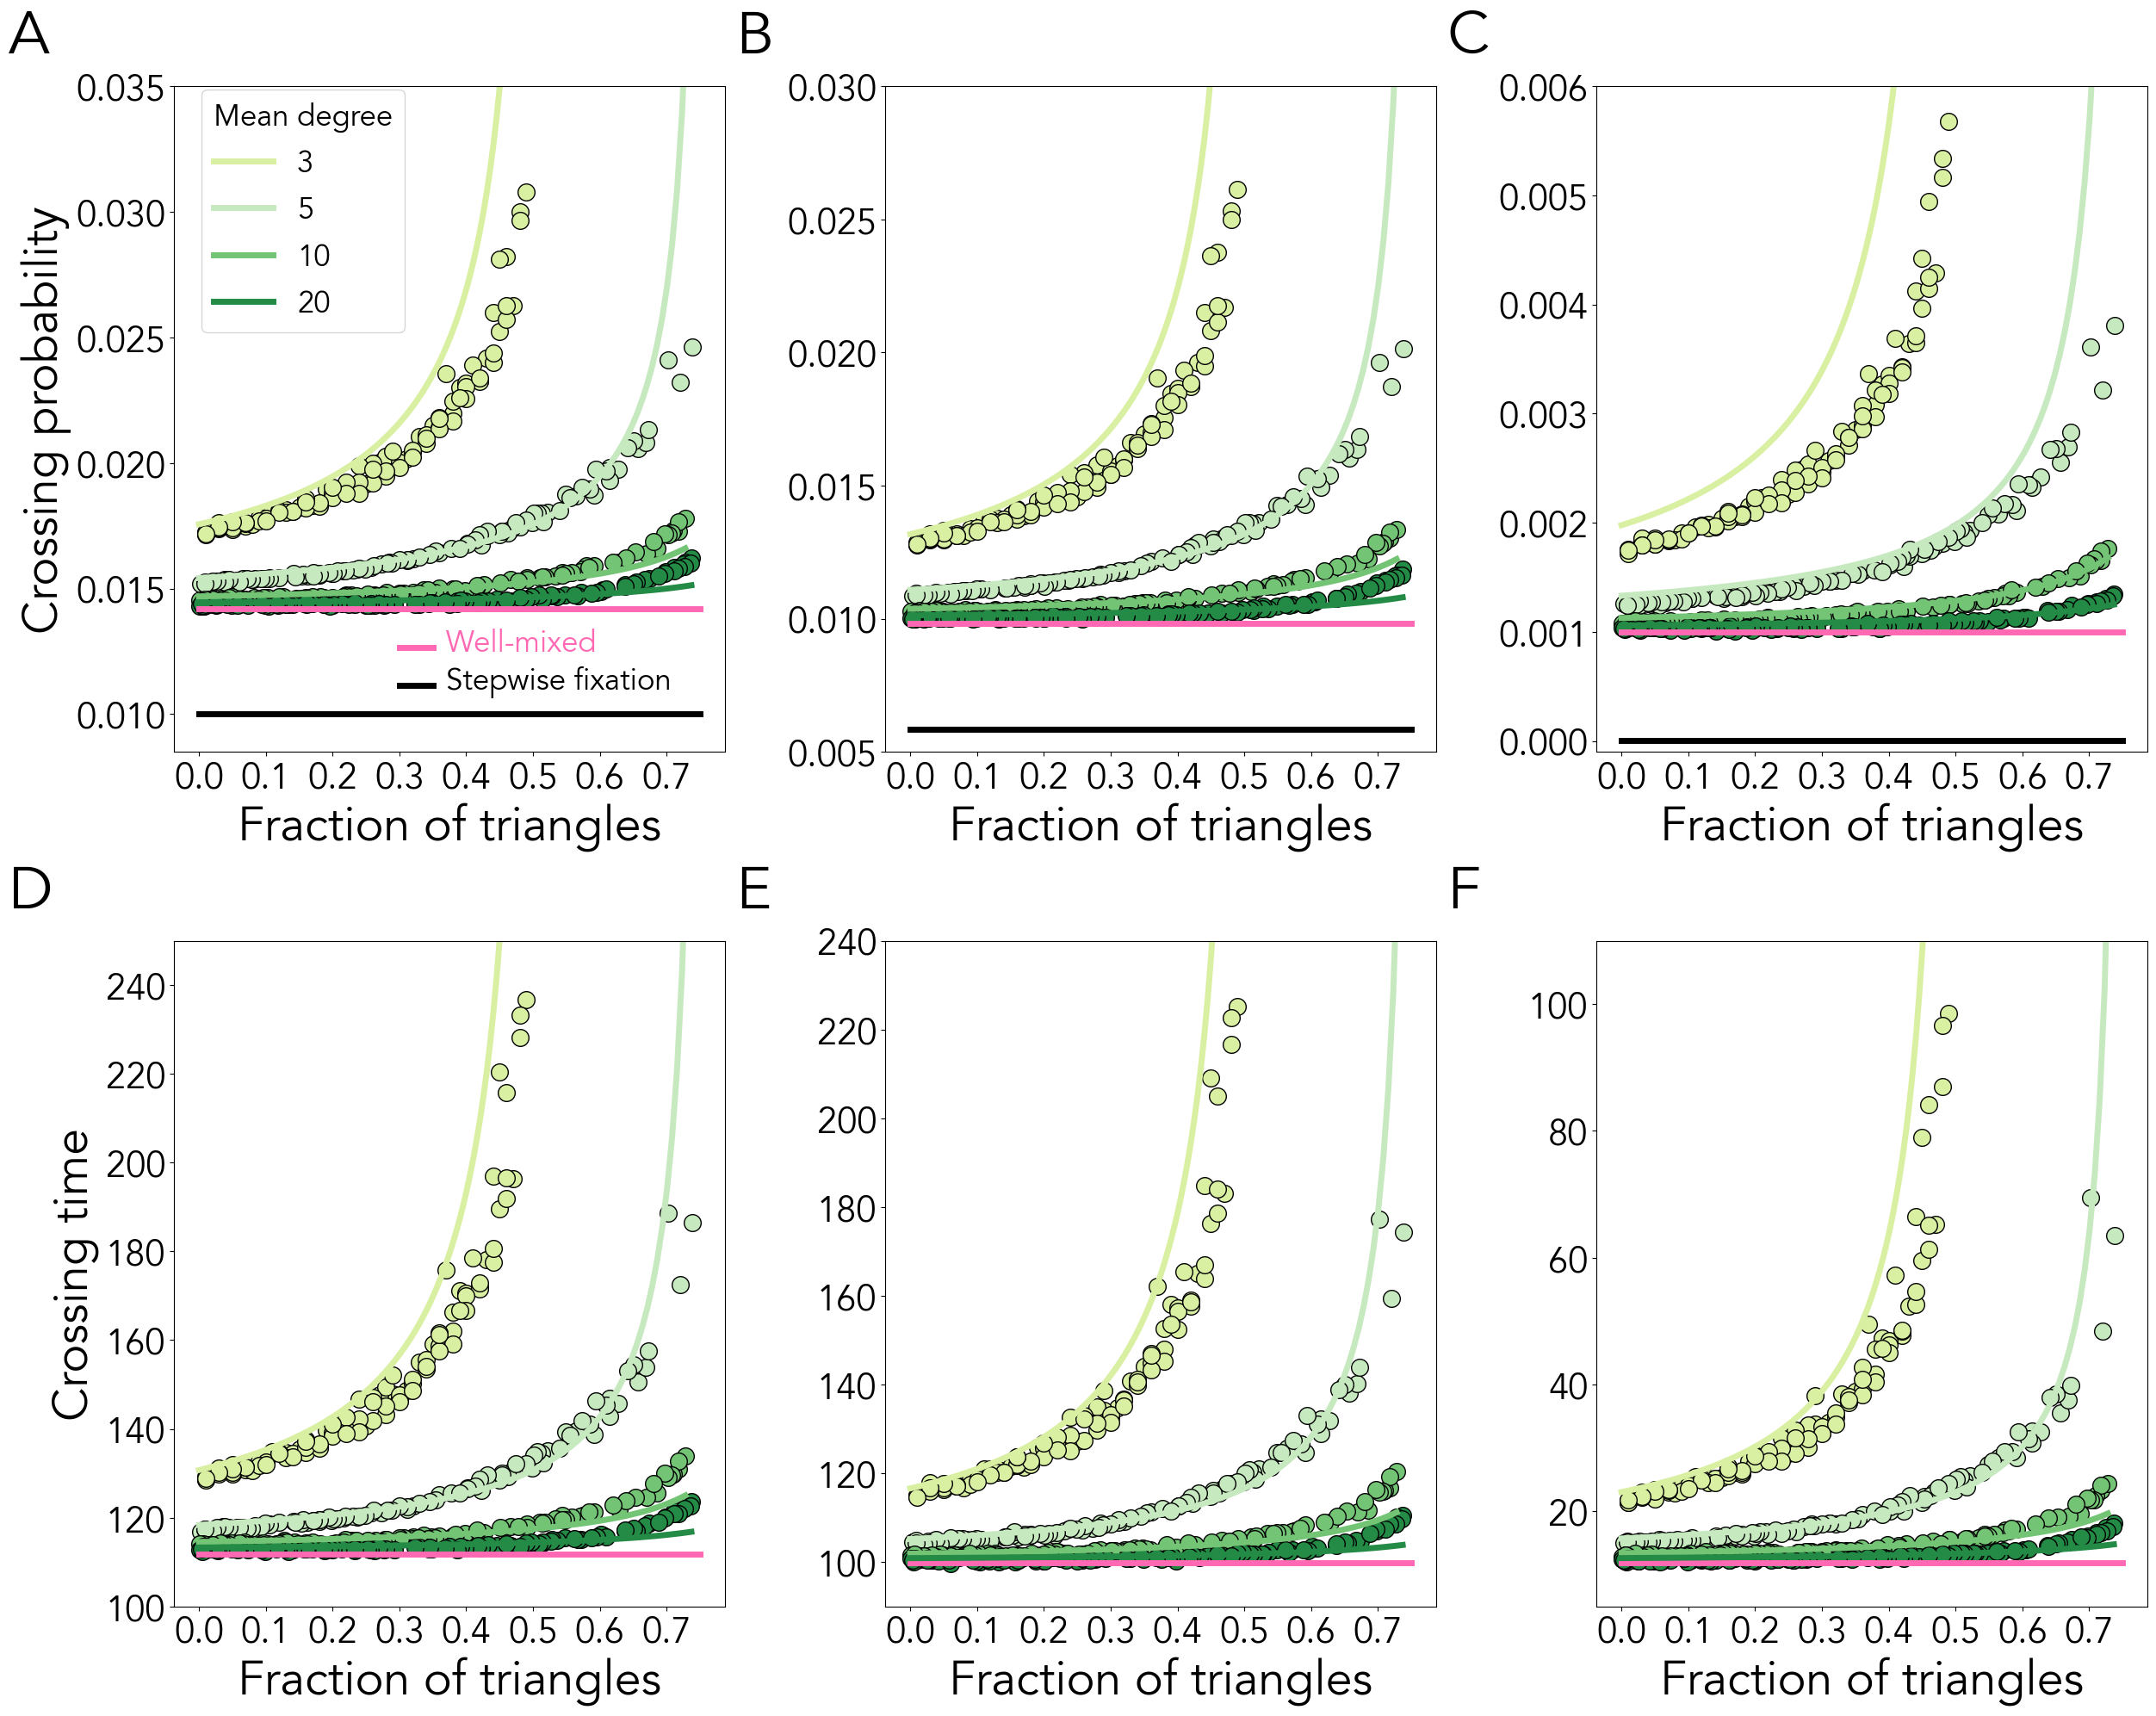

In [5]:
plt.figure(figsize = (25,20))
c = ['#d9f0a3','#c7e9c0', '#74c476', '#238b45', '#006d2c']
sns.set_palette(c)


ax = plt.subplot(231)
plt.plot([0,0.75], 2 * [control_bd[22,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,0.75], [0.01, 0.01],  color = 'k', linewidth = 5)
for i in range(4):
    x = data[200 * i:200 * (i + 1)]
    y = results_bd[200 * i:200 * (i + 1),1]
    
    x_approx = np.linspace(x[:,1].min(), x[:,1].max(), 100)
    lamb =  1 - 1 / (x[0,0] - 1) / (1 - x_approx)
    
    y_approx = [approximate(s = 0, lamb = l, N = 100) for l in lamb]
    
    plt.scatter(x[::2,1], y[::2], linewidth = 1, s = 200, edgecolor = 'k')

    plt.plot(x_approx, y_approx, linewidth = 5,
                label = int(data[200 * i, 0]))

leg = plt.legend(fontsize = 25,
          title = 'Mean degree', title_fontsize=25, loc = (0.05,0.63))
leg._legend_box.align = "left"

plt.ylim(0.0085, 0.035)

plt.plot([.3,.35], 2 * [0.01265],  color = '#ff69b4', linewidth = 5, zorder = 10)
plt.text(0.37, 0.0125, 'Well-mixed', c = '#ff69b4', fontsize = 25)

plt.plot([.3,.35], 2 * [0.01115], color = 'k', linewidth = 5, zorder = 10)
plt.text(0.37, 0.011, 'Stepwise fixation', fontsize = 25)

plt.xlabel('Fraction of triangles', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'A', fontsize = 50, transform=ax.transAxes)
plt.ylabel('Crossing probability', fontsize = 40)

#############################################################################
ax = plt.subplot(232)
plt.plot([0,0.75], 2 * [control_bd[12,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,0.75], 2 * [0.005832],  color = 'k', linewidth = 5)
for i in range(4):
    x = data[200 * i:200 * (i + 1)]
    y = results_bd[200 * i + 800: 200 * (i + 1) + 800,1]
    
    x_approx = np.linspace(x[:,1].min(), x[:,1].max(), 100)
    lamb =  1 - 1 / (x[0,0] - 1) / (1 - x_approx)
    
    y_approx = [approximate(s = -0.01, lamb = l, N = 100) for l in lamb]
    
    plt.scatter(x[::2,1], y[::2], linewidth = 1, s = 200, edgecolor = 'k')
    plt.plot(x_approx, y_approx, linewidth = 5)
    
plt.ylim(0.005, 0.03)

plt.xlabel('Fraction of triangles', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, ' B', fontsize = 50, transform=ax.transAxes)

#############################################################################
ax = plt.subplot(233)
plt.plot([0,0.75], 2 * [control_bd[3,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,0.75], 2 * [0.00000295],  color = 'k', linewidth = 5)
for i in range(4):
    x = data[200 * i:200 * (i + 1)]
    y = results_bd[200 * i + 1600: 200 * (i + 1) + 1600,1]
    
    x_approx = np.linspace(x[:,1].min(), x[:,1].max(), 100)
    lamb =  1 - 1 / (x[0,0] - 1) / (1 - x_approx)
    
    y_approx = [approximate(s = -0.1, lamb = l, N = 100) for l in lamb]
    
    plt.scatter(x[::2,1], y[::2], linewidth = 1, s = 200, edgecolor = 'k',)
    plt.plot(x_approx, y_approx, linewidth = 5)
    
plt.ylim(-0.0001, 0.006)

plt.xlabel('Fraction of triangles', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, ' C', fontsize = 50, transform=ax.transAxes)
#plt.text(0.3, 1.05, '$Ns = -10$', fontsize = 40, transform=ax.transAxes)

#############################################################################
ax = plt.subplot(234)
plt.plot([0,0.75], 2 * [control_bd[22,2] / 100],  color = '#ff69b4', linewidth = 5)

for i in range(4):
    x = data[200 * i:200 * (i + 1)]
    y = results_bd[200 * i:200 * (i + 1),2] / 100
    
    x_approx = np.linspace(x[:,1].min(), x[:,1].max(), 100)
    lamb =  1 - 1 / (x[0,0] - 1) / (1 - x_approx)
    
    y_approx = [approximate_t(s = 0, lamb = l) / 100 for l in lamb] 
    
    plt.scatter(x[::2,1], y[::2], linewidth = 1, s = 200, edgecolor = 'k',
                label = np.around(data[200 * i, 0],1))

    plt.plot(x_approx, y_approx, linewidth = 5)

plt.ylim(100,250)

plt.xlabel('Fraction of triangles', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'D', fontsize = 50, transform=ax.transAxes)
#plt.text(0.3, 1.05, '$Ns = 0$', fontsize = 40, transform=ax.transAxes)
plt.ylabel('Crossing time', fontsize = 40)

#############################################################################
ax = plt.subplot(235)
plt.plot([0,0.75], 2 * [control_bd[12,2] / 100],  color = '#ff69b4', linewidth = 5)
for i in range(4):
    x = data[200 * i:200 * (i + 1)]
    y = results_bd[200 * i + 800: 200 * (i + 1) + 800,2] / 100
    
    x_approx = np.linspace(x[:,1].min(), x[:,1].max(), 100)
    lamb =  1 - 1 / (x[0,0] - 1) / (1 - x_approx)
    
    y_approx = [approximate_t(s = -0.01, lamb = l) / 100 for l in lamb]
    
    plt.scatter(x[::2,1], y[::2], linewidth = 1, s = 200, edgecolor = 'k',)
    plt.plot(x_approx, y_approx, linewidth = 5)
    
plt.ylim(90, 240)

plt.xlabel('Fraction of triangles', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, ' E', fontsize = 50, transform=ax.transAxes)
#plt.text(0.3, 1.05, '$Ns = -1$', fontsize = 40, transform=ax.transAxes)


#############################################################################
ax = plt.subplot(236)
plt.plot([0,0.75], 2 * [control_bd[3,2] / 100],  color = '#ff69b4', linewidth = 5)
for i in range(4):
    x = data[200 * i:200 * (i + 1)]
    y = results_bd[200 * i + 1600: 200 * (i + 1) + 1600,2] / 100
    
    x_approx = np.linspace(x[:,1].min(), x[:,1].max(), 100)
    lamb =  1 - 1 / (x[0,0] - 1) / (1 - x_approx)
    
    y_approx = [approximate_t(s = -0.1, lamb = l) / 100 for l in lamb]
    
    plt.scatter(x[::2,1], y[::2], linewidth = 1, s = 200, edgecolor = 'k',)
    plt.plot(x_approx, y_approx, linewidth = 5)
    
plt.ylim(5, 110)

plt.xlabel('Fraction of triangles', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, ' F', fontsize = 50, transform=ax.transAxes)

plt.tight_layout()
plt.show()
#plt.savefig('supp_mean.pdf', bbox_inches='tight', pad_inches=0.1)

# Figure S3

In [6]:
control_bd, _ = process_s('wm-4s')

data = np.loadtxt('family_param.txt', comments='#')
factors = np.loadtxt('fam_bd_factors.txt')

data1 = np.loadtxt('complex_param.txt', comments='#')
factors1 = np.loadtxt('pt_bd_factors.txt')

done


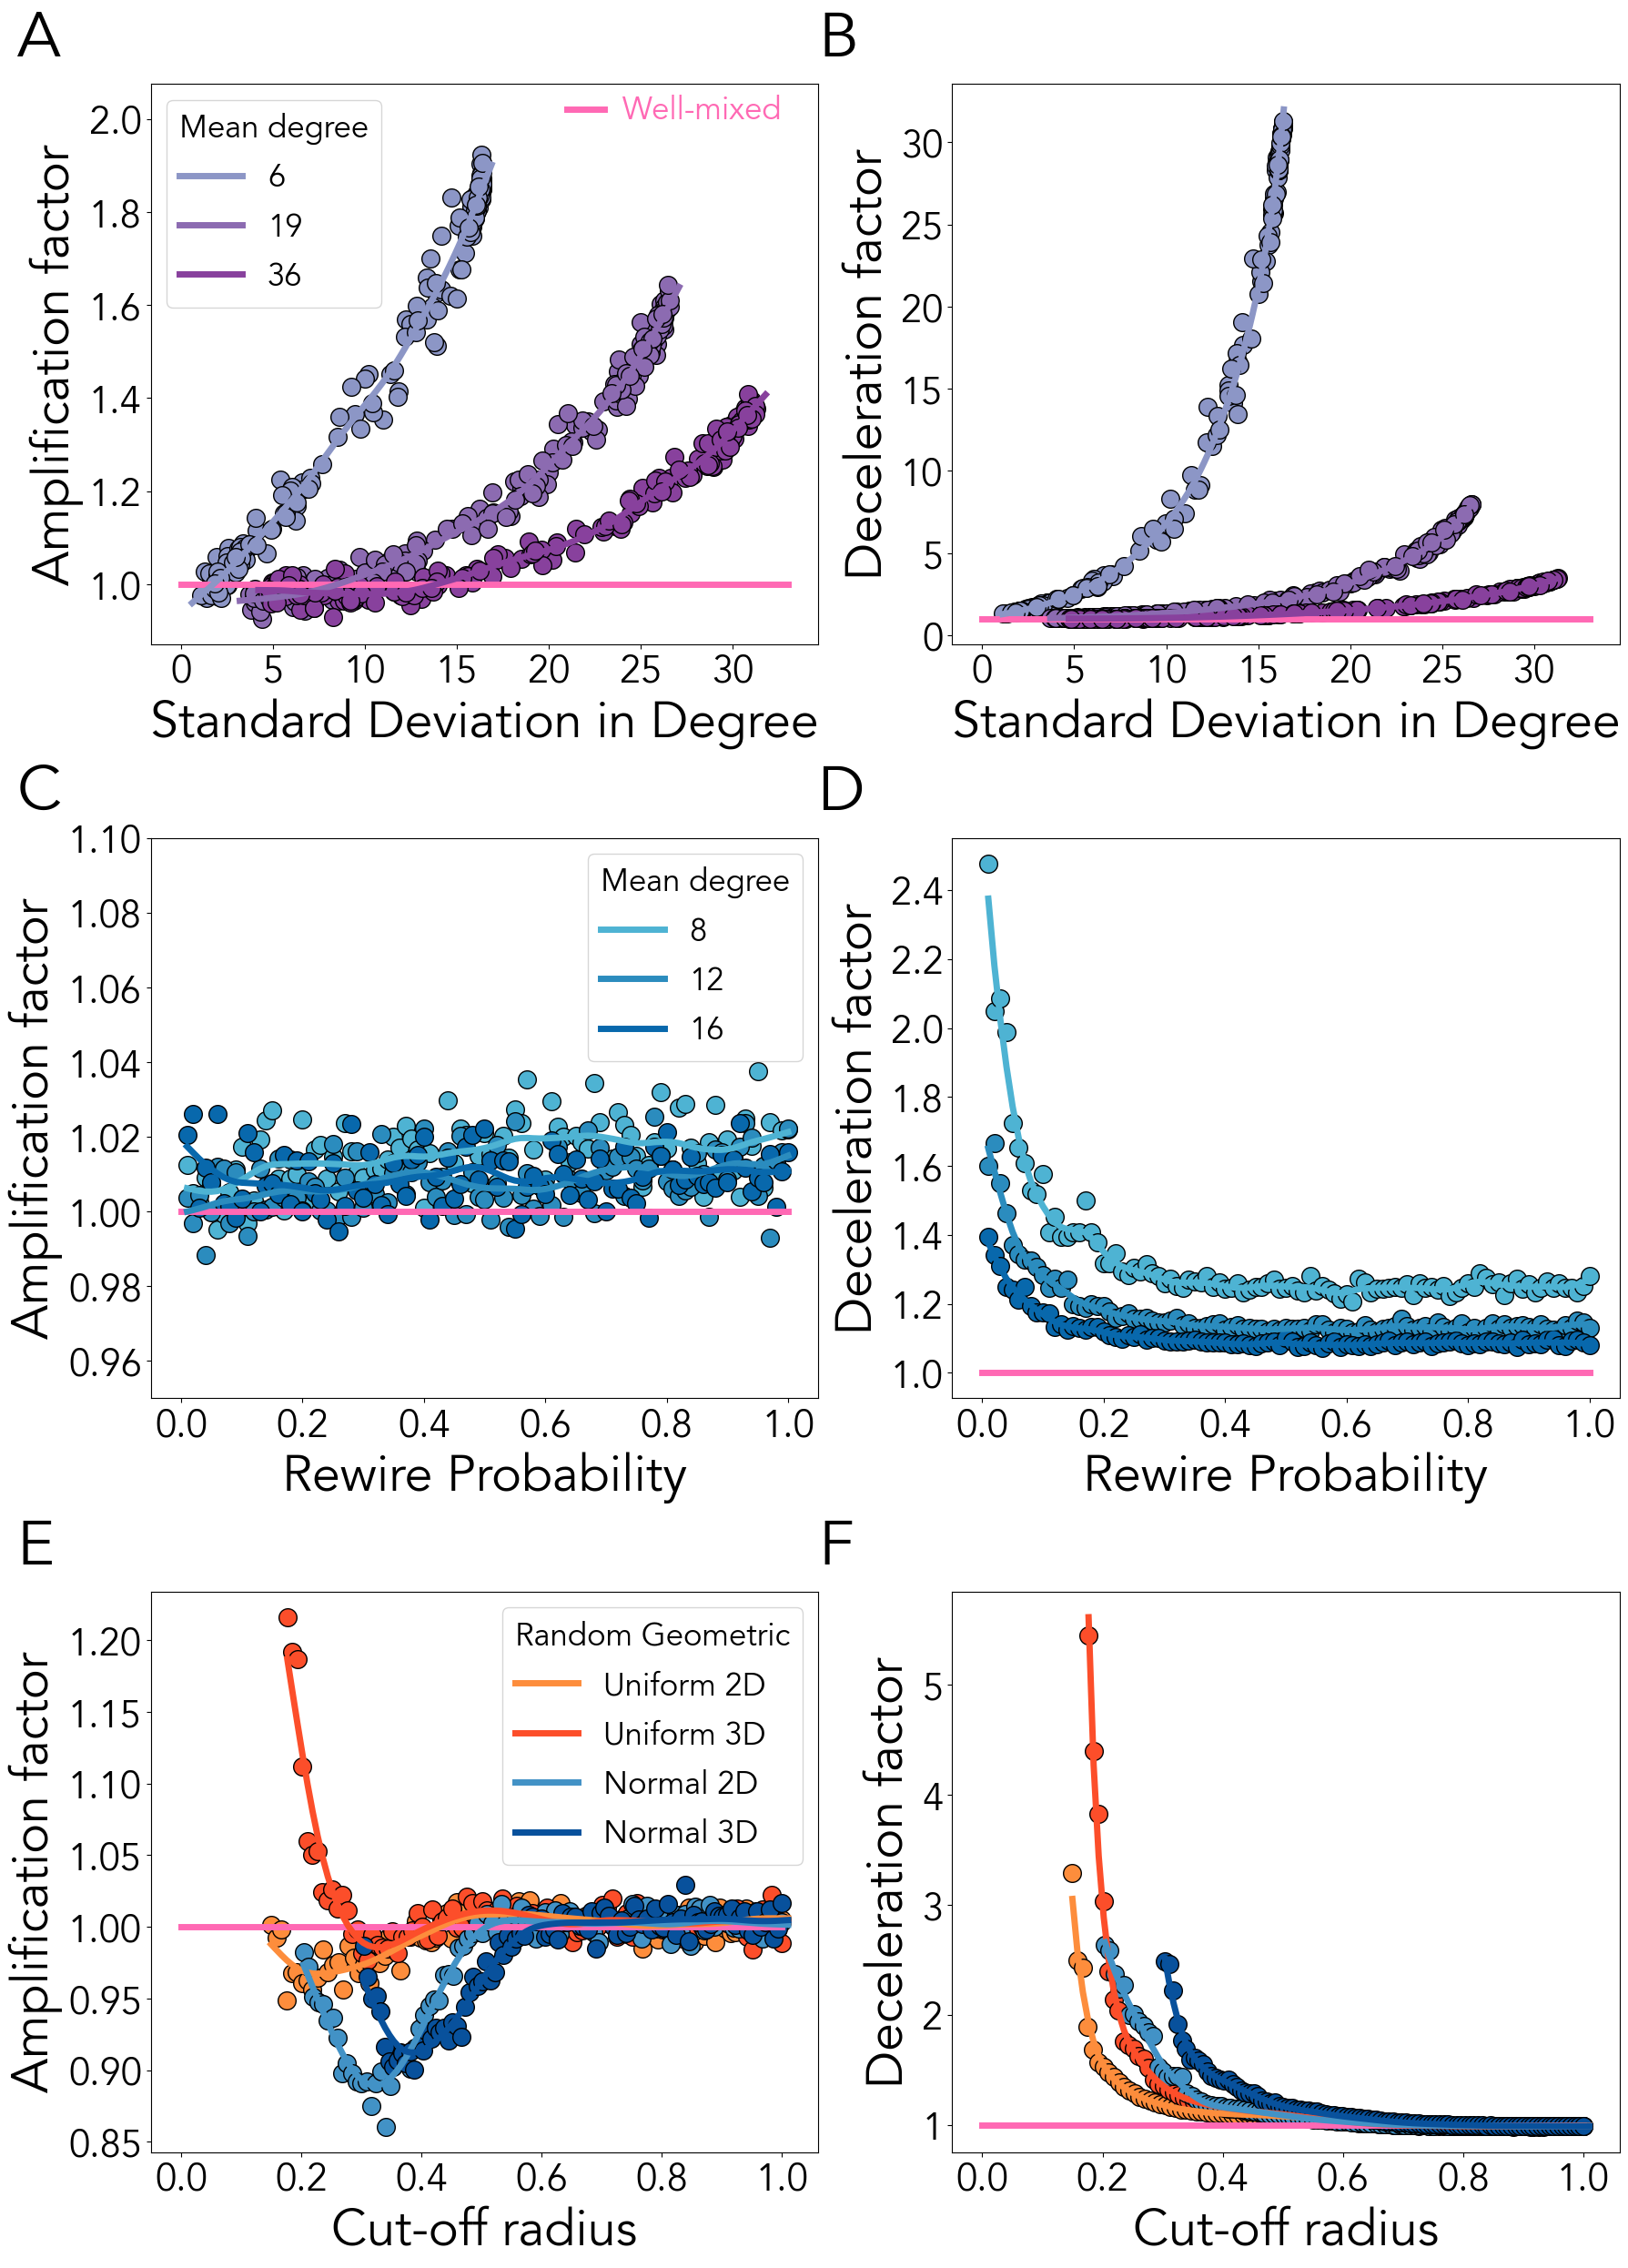

In [7]:
c = ['#8c96c6','#8c6bb1', '#88419d']
sns.set_palette(c)

plt.figure(figsize = (18,25))
ax = plt.subplot(321)

plt.plot([0,33], 2 * [1],  color = '#ff69b4', linewidth = 5)
for i in range(3):
    x = data1[200 * i:200 * (i + 1), 1]
    plt.scatter(x, factors1[200 * i:200 * (i + 1),0], linewidth = 1, s = 200, edgecolor = 'k')    
    
    x_approx, amp = trans(x, factors1[200 * i:200 * (i + 1),0], 0.1, [0.5, 0.5])
    plt.plot(x_approx, amp, linewidth = 5,
             label = int(np.around(data1[200 * i, 0],0)) )

plt.xlabel('Standard Deviation in Degree', fontsize = 40)
plt.ylabel('Amplification factor', fontsize = 40)

leg = plt.legend(fontsize = 25,
          title = 'Mean degree', title_fontsize=25)
leg._legend_box.align = "left"

plt.plot([21,23], 2 * [2.02],  color = '#ff69b4', linewidth = 5, zorder = 10)
plt.text(24, 2, 'Well-mixed', c = '#ff69b4', fontsize = 25)

#plt.ylim(.85, 2.3)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.2, 1.05, 'A', fontsize = 50, transform=ax.transAxes)

########################################################################
########################################################################
ax = plt.subplot(322)

plt.plot([0,33], 2 * [1],  color = '#ff69b4', linewidth = 5)
for i in range(3):
    x = data1[200 * i:200 * (i + 1), 1]
    plt.scatter(x, 1/factors1[200 * i:200 * (i + 1),1], linewidth = 1, s = 200, edgecolor = 'k')    
    
    x_approx, lamb = trans(x, factors1[200 * i:200 * (i + 1), 1], 0.1, [0, 0.01])
    plt.plot(x_approx, 1 / lamb, linewidth = 5)
    

plt.xlabel('Standard Deviation in Degree', fontsize = 40)
plt.ylabel('Deceleration factor', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.2, 1.05, 'B', fontsize = 50, transform=ax.transAxes)

########################################################################
########################################################################
label = ['Uniform 2D', 'Uniform 3D', 'Normal 2D', 'Normal 3D',
         '', 
         '8', '12', '16']

c = ['#4eb3d3', '#2b8cbe', '#0868ac']

sns.set_palette(c)

ax = plt.subplot(323)

plt.plot([0,1], 2 * [1],  color = '#ff69b4', linewidth = 5)
for i in range(5,8):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()

    plt.scatter(x, factors[100 * i:100 * (i + 1),0], linewidth = 1, s = 200, edgecolor = 'k')    
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    plt.plot(x, amp, linewidth = 5, label = label[i])
    
leg = plt.legend(fontsize = 25,
          title = 'Mean degree', title_fontsize=25)
leg._legend_box.align = "left"

plt.xlabel('Rewire probability', fontsize = 40)
plt.ylim(0.95,1.1)

plt.xlabel('Rewire Probability', fontsize = 40)
plt.ylabel('Amplification factor', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.2, 1.05, 'C', fontsize = 50, transform=ax.transAxes)

########################################################################
########################################################################
ax = plt.subplot(324)

plt.plot([0,1], 2 * [1],  color = '#ff69b4', linewidth = 5)
for i in range(5,8):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()

    plt.scatter(x, 1 / factors[100 * i:100 * (i + 1), 1], linewidth = 1, s = 200, edgecolor = 'k')    
    
    
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    plt.plot(x, 1 / lamb, linewidth = 5)
    

plt.xlabel('Rewire Probability', fontsize = 40)
plt.ylabel('Deceleration factor', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.2, 1.05, 'D', fontsize = 50, transform=ax.transAxes)

########################################################################
########################################################################
c = ['#fd8d3c', '#fc4e2a', '#4292c6', '#08519c']
sns.set_palette(c)

ax = plt.subplot(325)

plt.plot([0,1], 2 * [1],  color = '#ff69b4', linewidth = 5)
for i in range(4):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()

    plt.scatter(x, factors[100 * i:100 * (i + 1),0], linewidth = 1, s = 200, edgecolor = 'k')    
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    plt.plot(x_approx, amp, linewidth = 5, label = label[i])
    
leg = plt.legend(fontsize = 25,
          title = 'Random Geometric', title_fontsize=25)
leg._legend_box.align = "left"


plt.xlabel('Cut-off radius', fontsize = 40)
plt.ylabel('Amplification factor', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.2, 1.05, 'E', fontsize = 50, transform=ax.transAxes)

########################################################################
########################################################################
ax = plt.subplot(326)

plt.plot([0,1], 2 * [1],  color = '#ff69b4', linewidth = 5)
for i in range(4):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()

    plt.scatter(x, 1 / factors[100 * i:100 * (i + 1), 1], linewidth = 1, s = 200, edgecolor = 'k')    
    
    
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    plt.plot(x_approx, 1 / lamb, linewidth = 5)
    

plt.xlabel('Cut-off radius', fontsize = 40)
plt.ylabel('Deceleration factor', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.2, 1.05, 'F', fontsize = 50, transform=ax.transAxes)

plt.tight_layout()
#plt.savefig('supp_fit.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Figure S4

In [8]:
results_bd, results_db = process('family', 800)

done


meta NOT subset; don't know how to subset; dropped


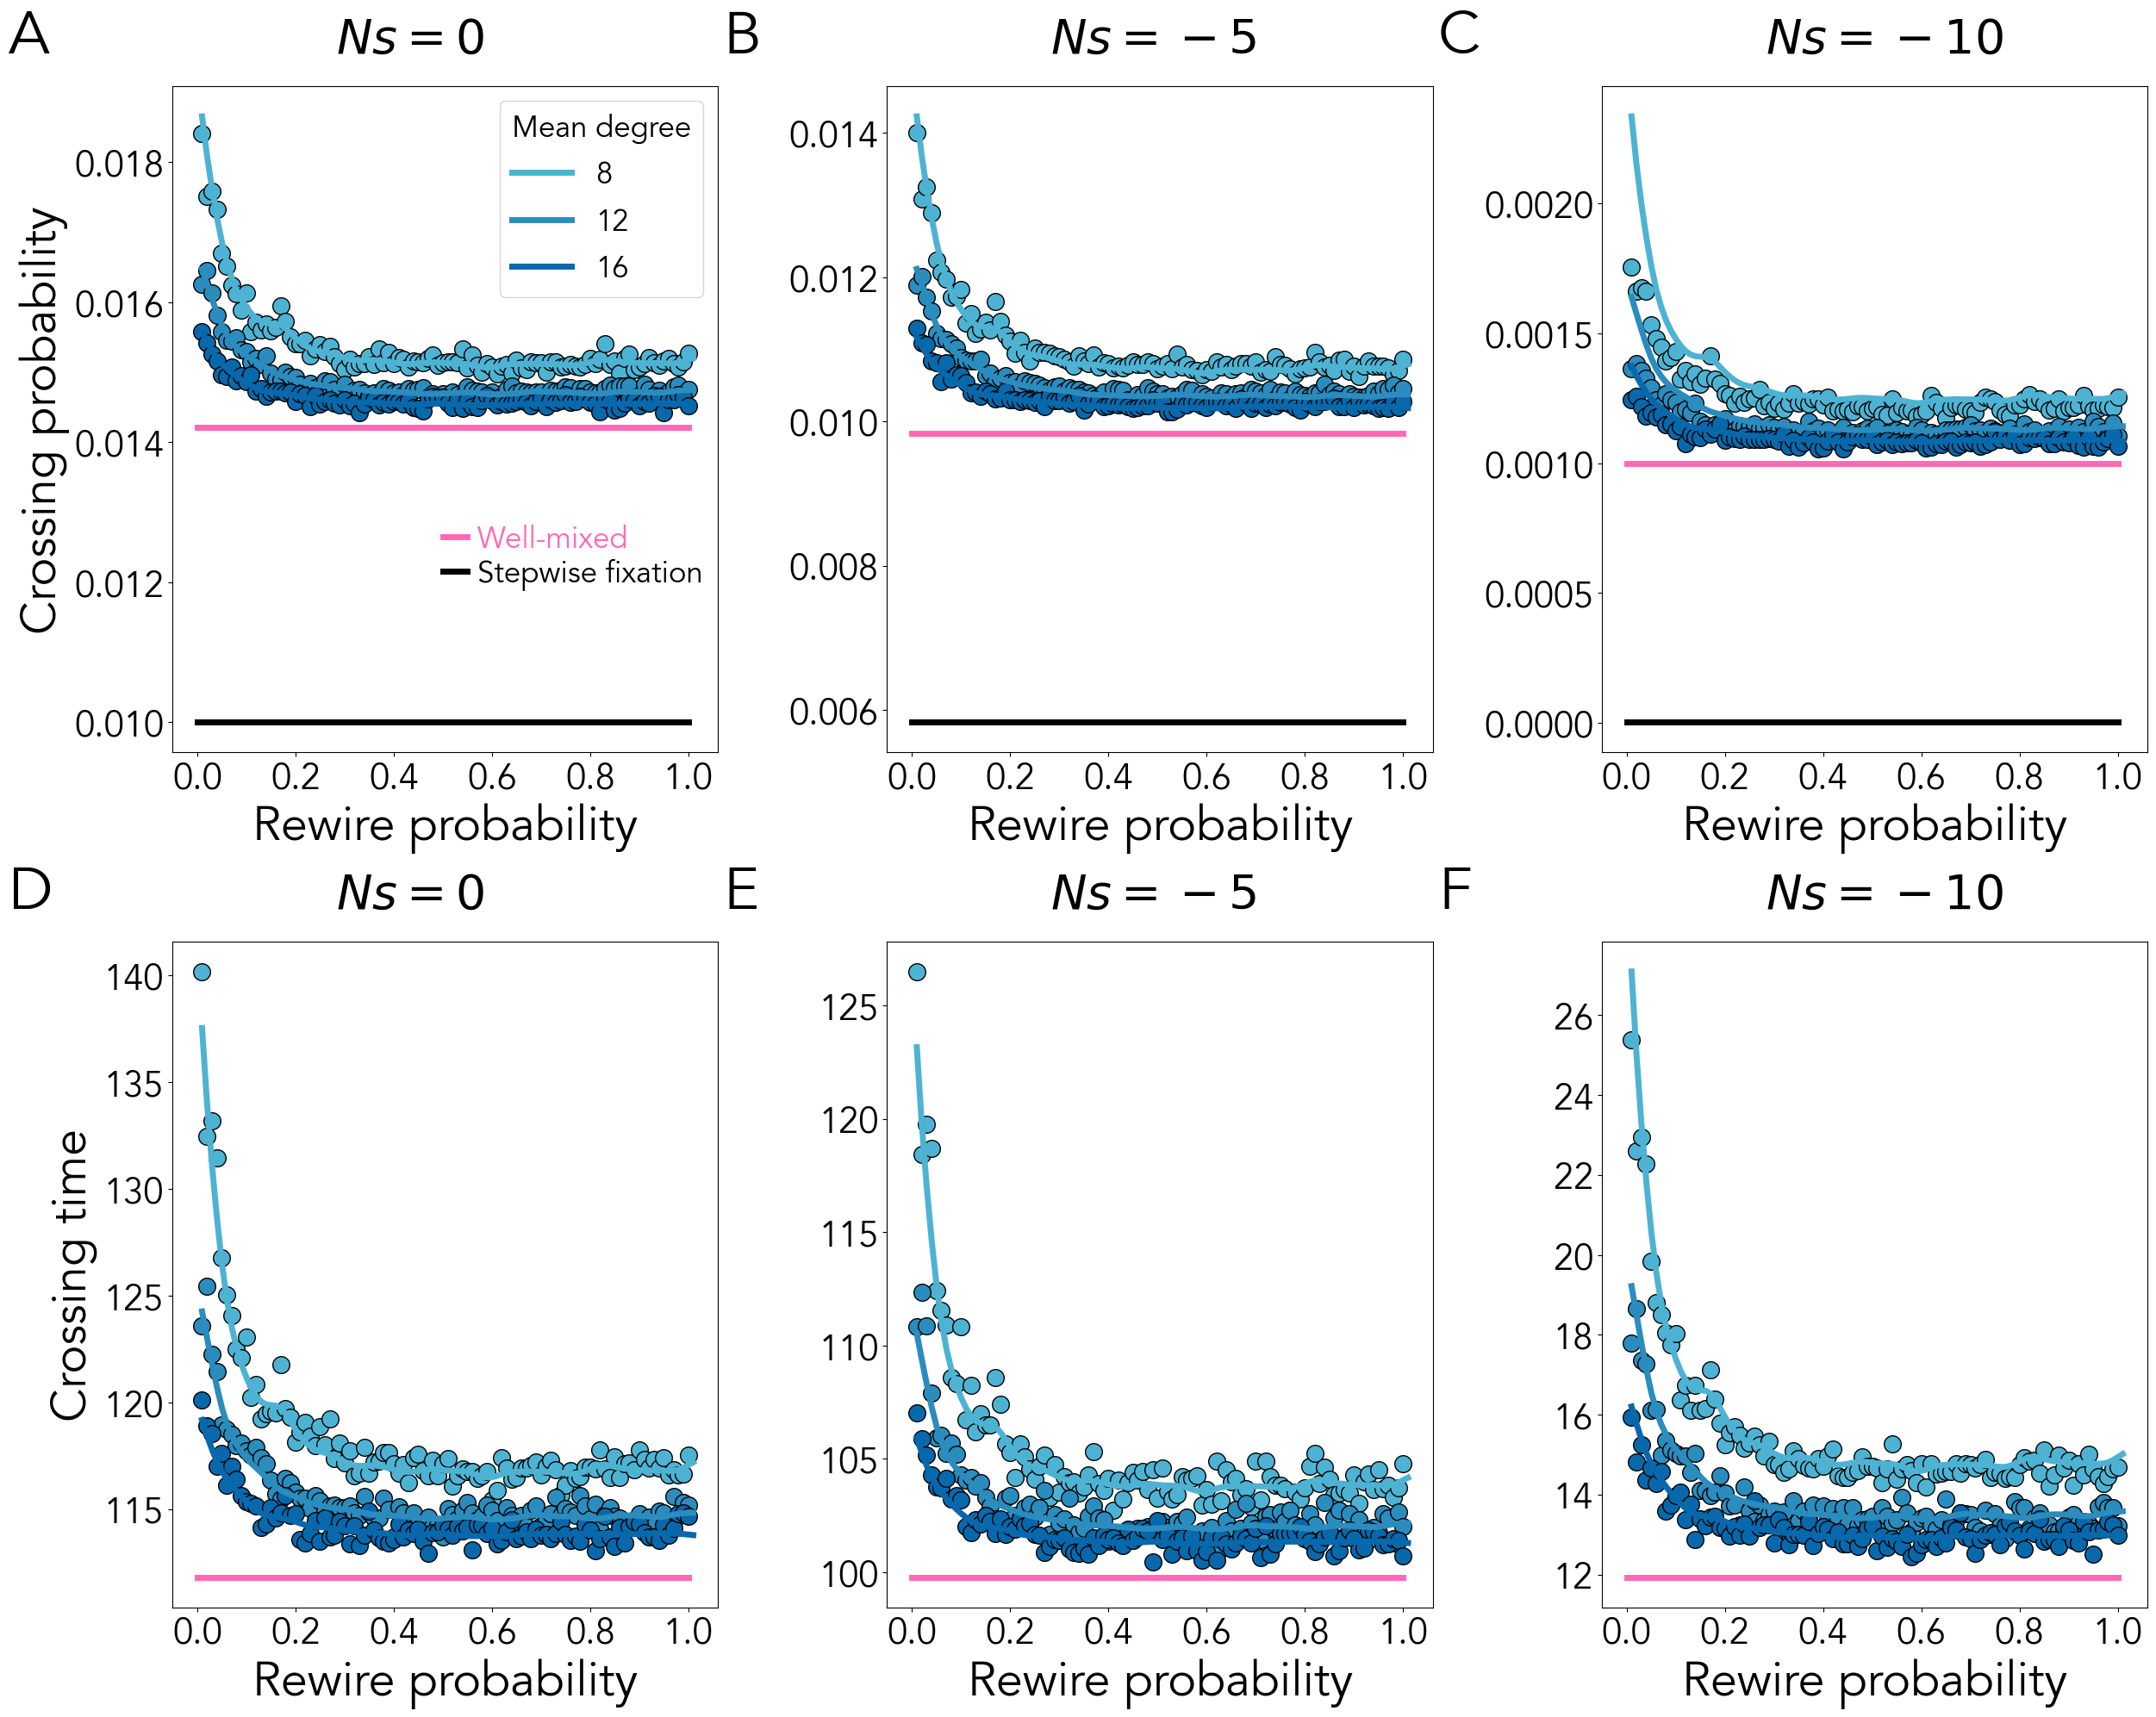

In [9]:
mu = 1e-4
label = ['8', '12', '16']
c = ['#4eb3d3', '#2b8cbe', '#0868ac']
sns.set_palette(c)

plt.figure(figsize = (25,20))
ax = plt.subplot(231)
plt.plot([0,1], 2 * [control_bd[22,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,1], 2 * [0.01],  color = 'k', linewidth = 5)
for i in range(5,8):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i:100 * (i + 1),1]
    
    plt.scatter(x, y, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = [approximate(s = 0, mu = mu, amp = amp[i], lamb = lamb[i], N = 100) 
                for i in range(len(amp))]
    plt.plot(x_approx, y_approx, linewidth = 5, label = label[i - 5])

leg = plt.legend(fontsize = 25,
          title = 'Mean degree', title_fontsize=25)
                 #title = 'Small-world', title_fontsize=25)
leg._legend_box.align = "left"


plt.plot([.5,.55], 2 * [0.01265],  color = '#ff69b4', linewidth = 5, zorder = 10)
plt.text(0.57, 0.0125, 'Well-mixed', c = '#ff69b4', fontsize = 25)

plt.plot([.5,.55], 2 * [0.01215], color = 'k', linewidth = 5, zorder = 10)
plt.text(0.57, 0.012, 'Stepwise fixation', fontsize = 25)

plt.xlabel('Rewire probability', fontsize = 40)
plt.ylabel('Crossing probability', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'A', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = 0$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(232)
plt.plot([0,1], 2 * [control_bd[12,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,1], 2 * [0.005832],  color = 'k', linewidth = 5)
for i in range(5,8):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i + 800:100 * (i + 1) + 800, 1]
    
    plt.scatter(x, y, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = [approximate(s = -0.01, mu = mu, amp = amp[i], lamb = lamb[i], N = 100) 
                for i in range(len(amp))]
    plt.plot(x_approx, y_approx, linewidth = 5)

plt.xlabel('Rewire probability', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'B', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = -5$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(233)
plt.plot([0,1], 2 * [control_bd[3,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,1], 2 * [0.00000295],  color = 'k', linewidth = 5)
for i in range(5,8):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i + 1600:100 * (i + 1) + 1600, 1]
    
    plt.scatter(x, y, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = [approximate(s = -0.1, mu = mu, amp = 1, lamb = lamb[i], N = 100) 
                for i in range(len(amp))]
    plt.plot(x_approx, y_approx, linewidth = 5)

plt.xlabel('Rewire probability', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'C', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = -10$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(234)
plt.plot([0,1], 2 * [control_bd[22, 2] / 100],  color = '#ff69b4', linewidth = 5)
for i in range(5,8):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i:100 * (i + 1),2]
    
    plt.scatter(x, y / 100, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = np.array([approximate_t(s = 0, mu = mu, amp = 1, lamb = lamb[i]) 
                         for i in range(len(amp))])
    plt.plot(x_approx, y_approx / 100, linewidth = 5)


plt.xlabel('Rewire probability', fontsize = 40)
plt.ylabel('Crossing time', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'D', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = 0$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(235)
plt.plot([0,1], 2 * [control_bd[12,2] / 100],  color = '#ff69b4', linewidth = 5)
for i in range(5,8):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i + 800:100 * (i + 1) + 800, 2]
    
    plt.scatter(x, y / 100, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = np.array([approximate_t(s = -0.01, mu = mu, amp = 1, lamb = lamb[i]) 
                         for i in range(len(amp))])
    plt.plot(x_approx, y_approx / 100, linewidth = 5)

plt.xlabel('Rewire probability', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'E', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = -5$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(236)
plt.plot([0,1], 2 * [control_bd[3,2] / 100],  color = '#ff69b4', linewidth = 5)
for i in range(5,8):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i + 1600:100 * (i + 1) + 1600, 2]
    
    plt.scatter(x, y / 100, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.999, [0., 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0., 0.01])
    
    y_approx = np.array([approximate_t(s = -0.1, mu = mu, amp = 1, lamb = lamb[i]) 
                         for i in range(len(amp))])
    plt.plot(x_approx, y_approx / 100, linewidth = 5)

plt.xlabel('Rewire probability', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'F', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = -10$', fontsize = 40, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('supp_sw.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Figure S5

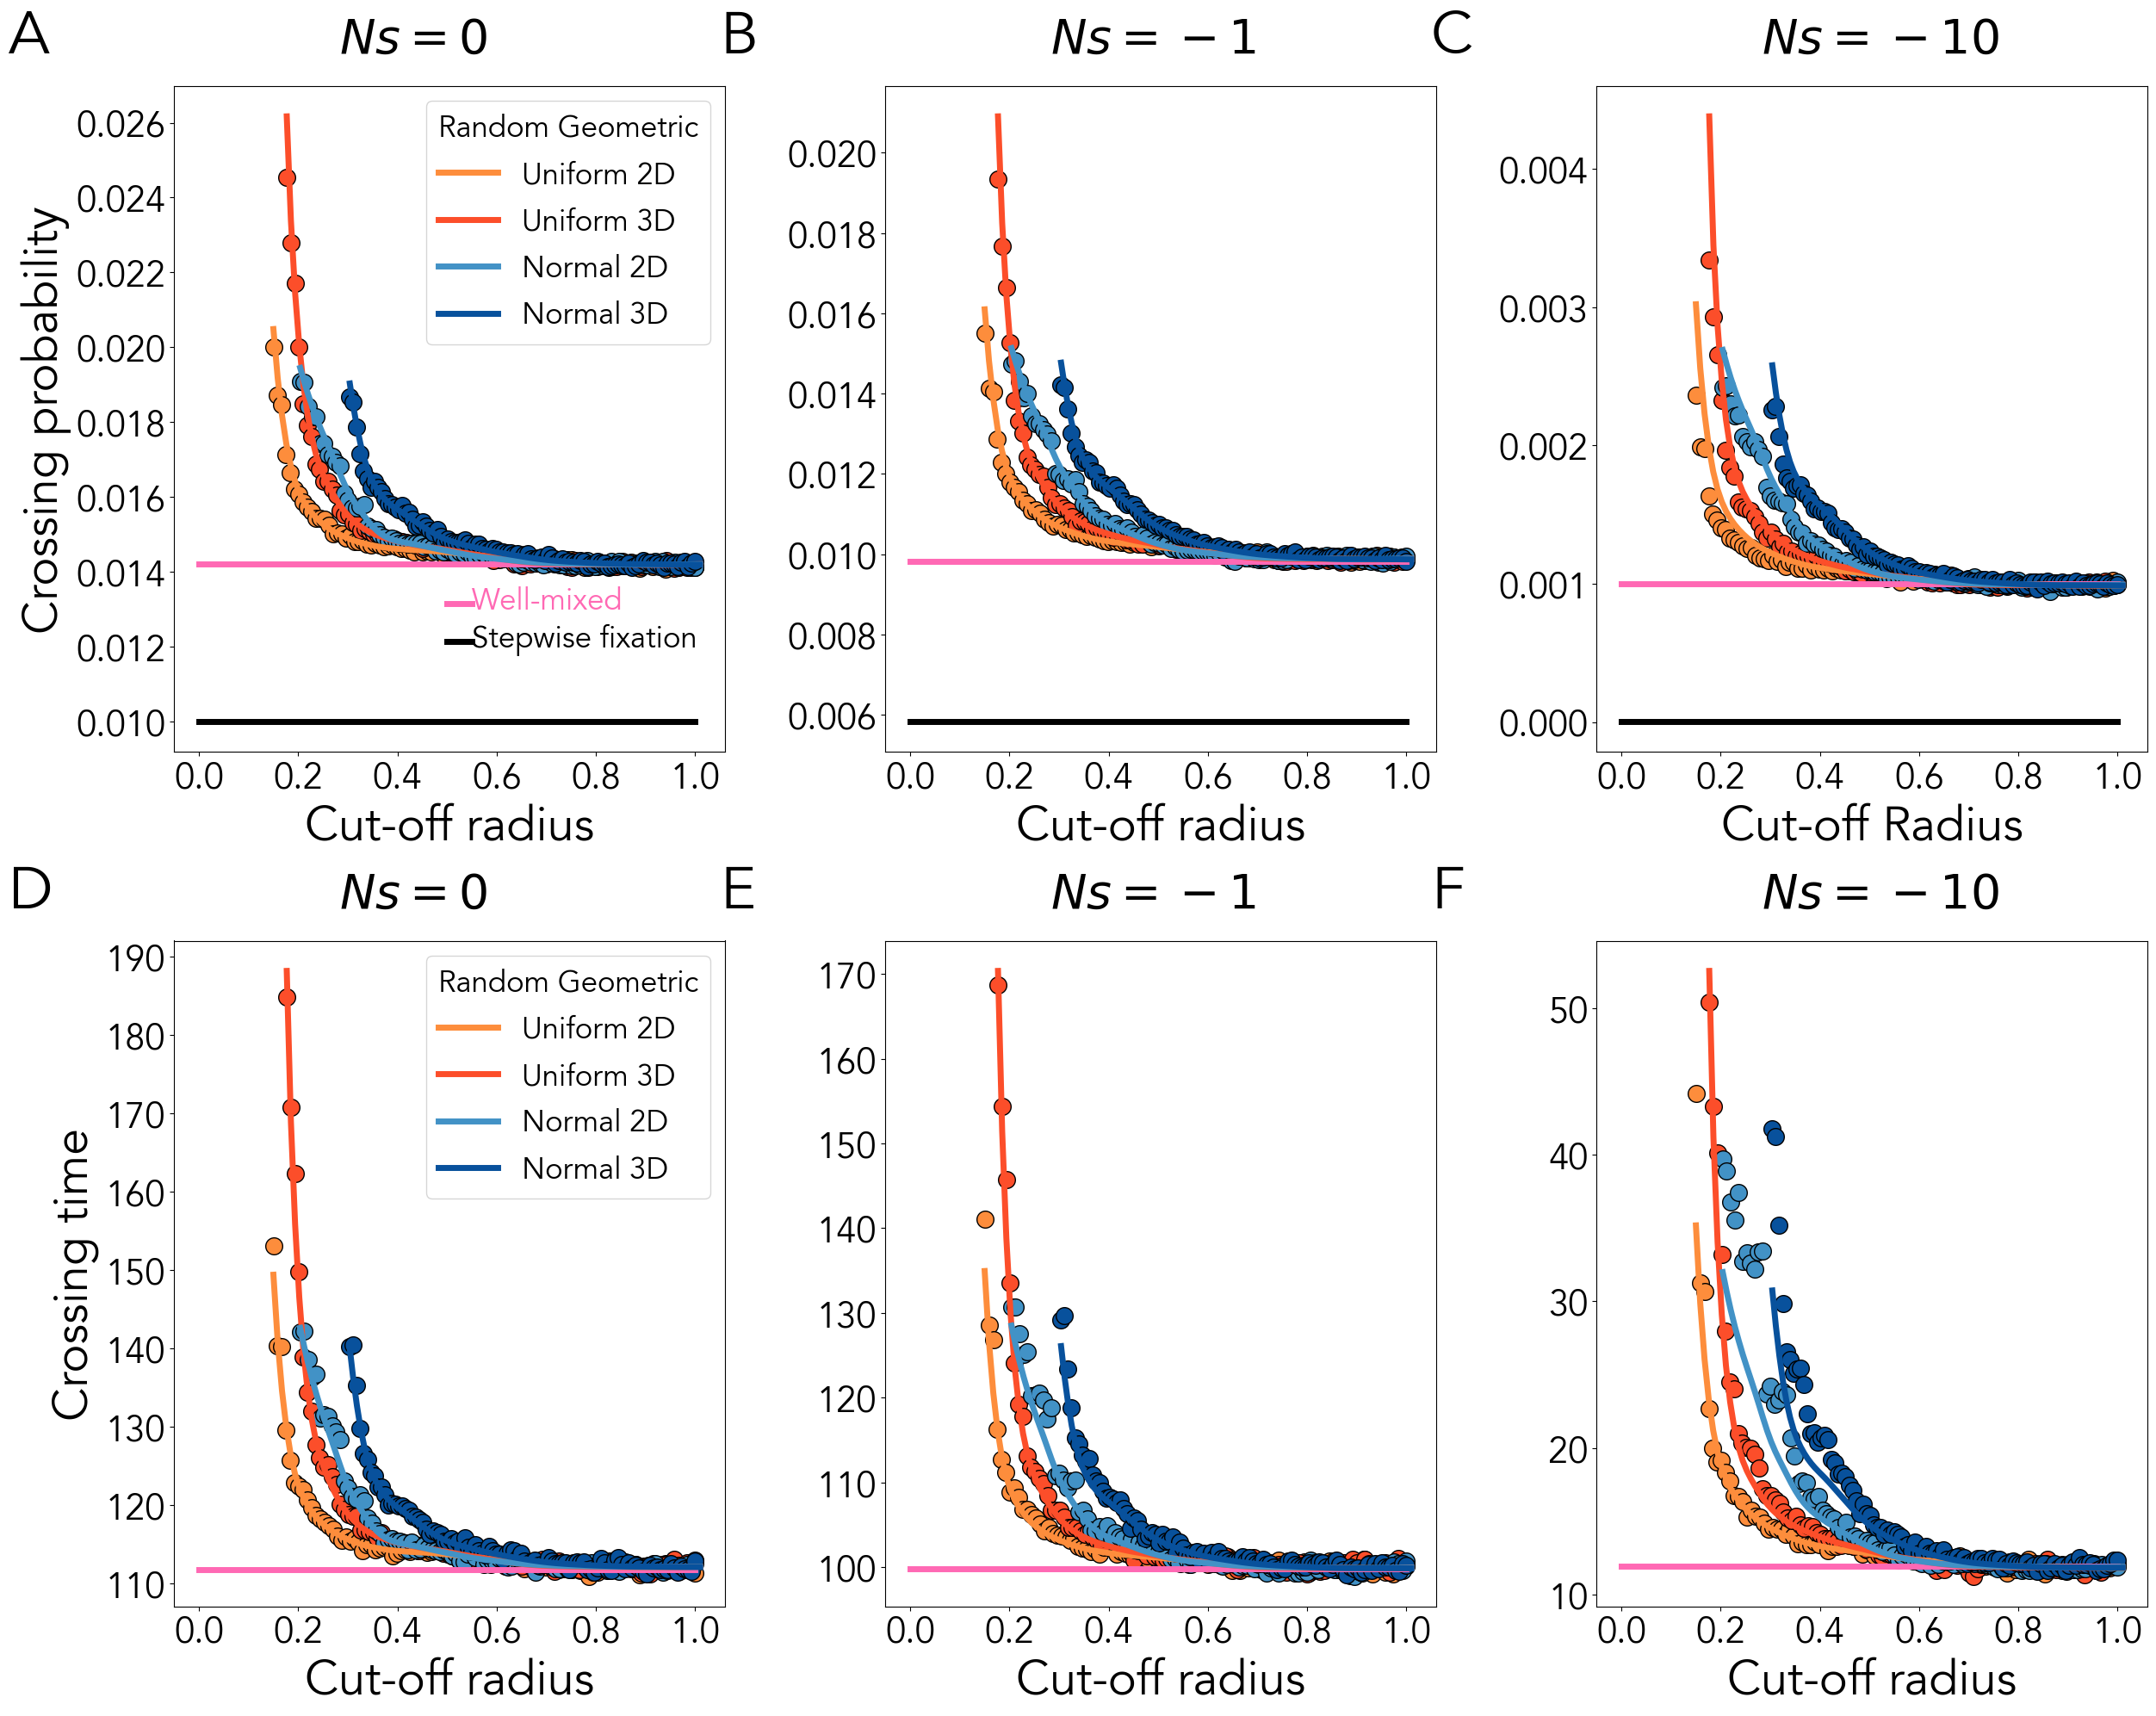

In [10]:
mu = 1e-4
label = ['Uniform 2D', 'Uniform 3D', 'Normal 2D', 'Normal 3D']
c = ['#fd8d3c', '#fc4e2a', '#4292c6', '#08519c']
sns.set_palette(c)

plt.figure(figsize = (25,20))
ax = plt.subplot(231)
plt.plot([0,1], 2 * [control_bd[22,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,1], 2 * [0.01],  color = 'k', linewidth = 5)
for i in range(4):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i:100 * (i + 1),1]
    
    plt.scatter(x, y, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = [approximate(s = 0, mu = mu, amp = amp[i], lamb = lamb[i], N = 100) 
                for i in range(len(amp))]
    plt.plot(x_approx, y_approx, linewidth = 5, label = label[i])

leg = plt.legend(fontsize = 25,
          title = 'Random Geometric', title_fontsize=25)
leg._legend_box.align = "left"

plt.plot([.5,.55], 2 * [0.01315],  color = '#ff69b4', linewidth = 5, zorder = 10)
plt.text(0.55, 0.013, 'Well-mixed', c = '#ff69b4', fontsize = 25)

plt.plot([.5,.55], 2 * [0.01215], color = 'k', linewidth = 5, zorder = 10)
plt.text(0.55, 0.012, 'Stepwise fixation', fontsize = 25)

plt.xlabel('Cut-off radius', fontsize = 40)
plt.ylabel('Crossing probability', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'A', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = 0$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(232)
plt.plot([0,1], 2 * [control_bd[12,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,1], 2 * [0.005832],  color = 'k', linewidth = 5)
for i in range(4):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i + 800:100 * (i + 1) + 800, 1]
    
    plt.scatter(x, y, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = [approximate(s = -0.01, mu = mu, amp = amp[i], lamb = lamb[i], N = 100) 
                for i in range(len(amp))]
    plt.plot(x_approx, y_approx, linewidth = 5)

plt.xlabel('Cut-off radius', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'B', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = -1$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(233)
plt.plot([0,1], 2 * [control_bd[3,1]],  color = '#ff69b4', linewidth = 5)
plt.plot([0,1], 2 * [0.00000295],  color = 'k', linewidth = 5)
for i in range(4):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i + 1600:100 * (i + 1) + 1600, 1]
    
    plt.scatter(x, y, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = [approximate(s = -0.1, mu = mu, amp = amp[i], lamb = lamb[i], N = 100) 
                for i in range(len(amp))]
    plt.plot(x_approx, y_approx, linewidth = 5)

plt.xlabel('Cut-off Radius', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'C', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = -10$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(234)
plt.plot([0,1], 2 * [control_bd[22, 2] / 100],  color = '#ff69b4', linewidth = 5)
for i in range(4):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i:100 * (i + 1),2]
    
    plt.scatter(x, y / 100, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = np.array([approximate_t(s = 0, mu = mu, amp = amp[i], lamb = lamb[i]) 
                         for i in range(len(amp))])
    plt.plot(x_approx, y_approx / 100, linewidth = 5, label = label[i])

leg = plt.legend(fontsize = 25,
          title = 'Random Geometric', title_fontsize=25)
leg._legend_box.align = "left"

plt.xlabel('Cut-off radius', fontsize = 40)
plt.ylabel('Crossing time', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'D', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = 0$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(235)
plt.plot([0,1], 2 * [control_bd[12,2] / 100],  color = '#ff69b4', linewidth = 5)
for i in range(4):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i + 800:100 * (i + 1) + 800, 2]
    
    plt.scatter(x, y / 100, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.9999, [0, 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0, 0.01])
    
    y_approx = np.array([approximate_t(s = -0.01, mu = mu, amp = amp[i], lamb = lamb[i]) 
                         for i in range(len(amp))])
    plt.plot(x_approx, y_approx / 100, linewidth = 5)

plt.xlabel('Cut-off radius', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'E', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = -1$', fontsize = 40, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(236)
plt.plot([0,1], 2 * [control_bd[3,2] / 100],  color = '#ff69b4', linewidth = 5)
for i in range(4):
    x = data[100 * i:100 * (i + 1), 1]
    x /= x.max()
    y = results_bd[100 * i + 1600:100 * (i + 1) + 1600, 2]
    
    plt.scatter(x, y / 100, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[100 * i:100 * (i + 1),0], 0.999, [0., 0.01])
    x_approx, lamb = trans(x, factors[100 * i:100 * (i + 1), 1], 0.99999, [0., 0.01])
    
    y_approx = np.array([approximate_t(s = -0.1, mu = mu, amp = amp[i], lamb = lamb[i]) 
                         for i in range(len(amp))])
    plt.plot(x_approx, y_approx / 100, linewidth = 5)

plt.xlabel('Cut-off radius', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.text(-0.3, 1.05, 'F', fontsize = 50, transform=ax.transAxes)
plt.text(0.3, 1.05, '$Ns = -10$', fontsize = 40, transform=ax.transAxes)

plt.tight_layout()
#plt.savefig('bd_rgg_100_1e-4_approx.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Figure S6

In [11]:
ls = list(range(8,160,10))
s = np.linspace(-15, -1, 15)
s = np.hstack((s, np.linspace(-0.9, -0.1, 9)))
s = np.hstack((s, [-0.03,0,0.03]))
s = np.hstack((s, np.linspace(0.1, 0.9, 9)))
s = np.hstack((s, np.linspace(1, 15, 15)))


runs = 10 * [1e6] + 10 * [5e5] + 31 * [1e5]

In [12]:
nl = []

for i in np.array(ls):
    g = nx.read_edgelist('bm_short/{:d}.txt'.format(i), data=False)
    nl += [len(g)]
    
nl = np.array(nl)

In [13]:
alpha = np.loadtxt('bone_bd_factors.txt')[:,0]

In [14]:
def out_mu():
    raw = np.zeros((2 * 51 * 16, 4))

    data_bd = np.zeros((51 * 16, 4))
    data_db = np.zeros((51 * 16, 4))
    count = np.zeros(51 * 16 * 2)
    
    for i in range(8160):
        try:
            data = np.loadtxt('bm_s_results/%g.txt'%i)
            raw[2 * (i % (51 * 16)): 2 * (i % (51 * 16) + 1), :3] += data[:,[0,1,2]]
            raw[2 * (i % (51 * 16)): 2 * (i % (51 * 16) + 1), 3] += data[:,2] * data[:,4]
            count[2 * (i % (51 * 16)): 2 * (i % (51 * 16) + 1)] += 1
        except:
            print(i)
            
    raw[:,0] = raw[:,0] / count
    raw[:,3] = raw[:,3] / raw[:,2]

    data_bd[:,[0,2]] = raw[::2,[0,3]]
    data_bd[:,1] = raw[::2,2] / (raw[::2,1] + raw[::2,2])  

    data_db[:,[0,2]] = raw[1::2,[0,3]] 
    data_db[:,1] = raw[1::2,2] / (raw[1::2,1] + raw[1::2,2])  
    
    return data_bd, data_db

results_bd, _ = out_mu()

102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
161
169
206
209
210
211
212
213
255
256
257
258
259
260
261
262
263
264
271
272
273
306
307
308
309
310
311
312
313
314
315
321
358
359
360
361
362
363
364
365
366
372
373
408
409
410
411
412
413
414
415
416
417
418
419
421
422
423
424
425
427
459
461
465
466
467
468
510
511
512
514
515
516
517
518
519
527
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
671
766
771
772
773
774
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
940
950
951
961
971
974
977
981
985
1020
1026
1027
1028
1029
1037
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1083
1084
1087
1090
1122
1123
1124
1125
1126
1127
1128
1130
1131
1134
1140
1141
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1189
1190
1191
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243

8123
8124
8125
8128


/var/folders/dn/kt6f6_td4dl2qrsg4wnv22z80000gn/T/ipykernel_67083/856252144.py:17: RuntimeWarning: invalid value encountered in divide
  raw[:,0] = raw[:,0] / count
/var/folders/dn/kt6f6_td4dl2qrsg4wnv22z80000gn/T/ipykernel_67083/856252144.py:18: RuntimeWarning: invalid value encountered in divide
  raw[:,3] = raw[:,3] / raw[:,2]
/var/folders/dn/kt6f6_td4dl2qrsg4wnv22z80000gn/T/ipykernel_67083/856252144.py:21: RuntimeWarning: invalid value encountered in divide
  data_bd[:,1] = raw[::2,2] / (raw[::2,1] + raw[::2,2])
/var/folders/dn/kt6f6_td4dl2qrsg4wnv22z80000gn/T/ipykernel_67083/856252144.py:24: RuntimeWarning: invalid value encountered in divide
  data_db[:,1] = raw[1::2,2] / (raw[1::2,1] + raw[1::2,2])


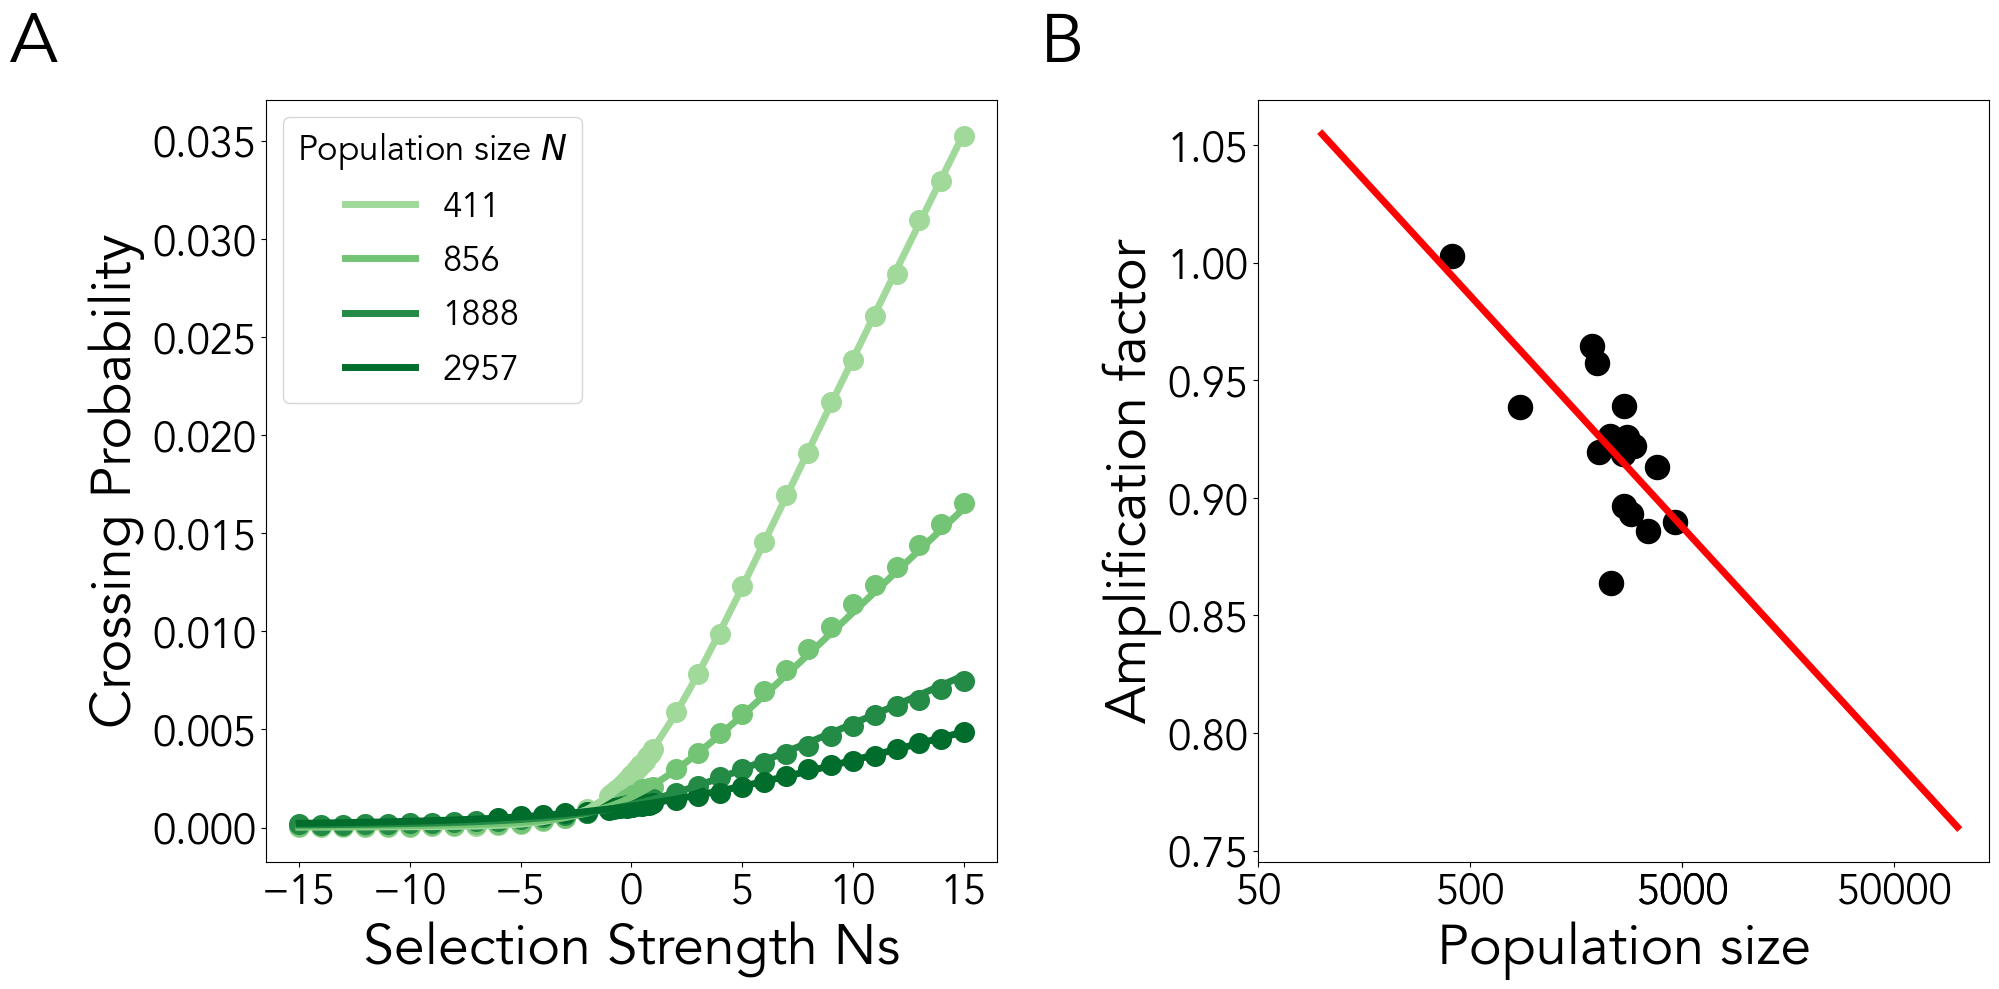

In [15]:
c = ['#006d2c','#238b45','#74c476', '#a1d99b'][::-1]
sns.set_palette(c)

plt.figure(figsize = (20,10))
ax = plt.subplot(122)
plt.scatter(np.log10(nl), alpha,s = 300, c = 'k')

reg = LinearRegression().fit(np.log10(nl)[:, None], alpha)

plt.plot([2,5], reg.intercept_ + reg.coef_ * np.array([2,5]), c= 'r', linewidth = 5)

plt.xlabel('Population size', fontsize = 40)
plt.ylabel('Amplification factor', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(np.log10([50,500,5000, 5000, 50000]), [50,500,5000, 5000, 50000],fontsize = 30)

plt.text(-0.35, 1.05, '  B', fontsize = 50, transform=ax.transAxes)

ax = plt.subplot(121)
i = 1
wm = np.array([approximate(s = s, mu = 1e-6, N = nl[i]) 
              for s in s / nl[i]]) 

y = np.array([approximate(s = s, mu = 1e-6, amp = alpha[i], N = nl[i]) 
              for s in s / nl[i]]) 
plt.scatter(s, results_bd[51 * i:51 * (i + 1),1], s = 200, label='_nolegend_')
plt.plot(s, y, linewidth = 5)


i = 0
wm = np.array([approximate(s = s, mu = 1e-6, N = nl[i]) 
              for s in s / nl[i]]) 

y = np.array([approximate(s = s, mu = 1e-6, amp = alpha[i], N = nl[i]) 
              for s in s / nl[i]]) 
plt.scatter(s, results_bd[51 * i:51 * (i + 1),1], s = 200, label='_nolegend_')
plt.plot(s, y, linewidth = 5)


i = 4
wm = np.array([approximate(s = s, mu = 1e-6, N = nl[i]) 
              for s in s / nl[i]]) 

y = np.array([approximate(s = s, mu = 1e-6, amp = alpha[i], N = nl[i]) 
              for s in s / nl[i]]) 
plt.scatter(s, results_bd[51 * i:51 * (i + 1),1], s = 200, label='_nolegend_')
plt.plot(s, y, linewidth = 5)


i = 5
wm = np.array([approximate(s = s, mu = 1e-6, N = nl[i]) 
              for s in s / nl[i]]) 

y = np.array([approximate(s = s, mu = 1e-6, amp = alpha[i], N = nl[i]) 
              for s in s / nl[i]]) 
plt.scatter(s, results_bd[51 * i:51 * (i + 1),1], s = 200, label='_nolegend_')
plt.plot(s, y, linewidth = 5)

plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)

plt.xlabel('Selection Strength Ns', fontsize = 40)
plt.ylabel('Crossing Probability', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)

leg = plt.legend(nl[[1,0,4,5]], fontsize = 25,
          title = 'Population size $N$', title_fontsize=25)

plt.text(-0.35, 1.05, 'A', fontsize = 50, transform=ax.transAxes)

plt.tight_layout()
#plt.savefig('bone_supp.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()